In [1]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import numpy as np
import pandas as pd
from keras import losses
import random
import matplotlib.pyplot as plt
from sklearn.svm import SVR

Using TensorFlow backend.


In [2]:
# read dataset
data = pd.read_csv('data_duration.csv')
data = data.drop(['times','events','duration_s'], axis=1)
data.head()

,year,month,date,academic_year,semester,week,weekday,hour,subject,student_level,number_of_tutors,duration_m
0,2015,2,3,2014/2015,2,1,2,16,MATH,2,2.0,29.0
1,2015,2,5,2014/2015,2,1,4,11,ACM,1,3.0,16.0
2,2015,2,6,2014/2015,2,1,5,11,MATH,1,2.0,128.0
3,2015,2,6,2014/2015,2,1,5,11,MATH,1,2.0,42.0
4,2015,2,6,2014/2015,2,1,5,11,MATH,2,2.0,2.0


In [3]:
# remove data whose subject is not 'MATH'
data = data[data.subject == 'MATH']
data = data.drop('subject', axis=1)
data.head()

,year,month,date,academic_year,semester,week,weekday,hour,student_level,number_of_tutors,duration_m
0,2015,2,3,2014/2015,2,1,2,16,2,2.0,29.0
2,2015,2,6,2014/2015,2,1,5,11,1,2.0,128.0
3,2015,2,6,2014/2015,2,1,5,11,1,2.0,42.0
4,2015,2,6,2014/2015,2,1,5,11,2,2.0,2.0
5,2015,2,6,2014/2015,2,1,5,12,1,2.0,62.0


In [4]:
# data preparation
data = data[data.week != 0]
data = data[data.semester != 3]
data = data[data.hour >= 10]
data = data[data.hour <= 20]
data = data[data.weekday <= 5]
data = data[data.number_of_tutors != 0]
data = data[data.duration_m > 0]
data = data[data.duration_m <= 120]
data = data.drop('academic_year', axis=1)
data.head()

,year,month,date,semester,week,weekday,hour,student_level,number_of_tutors,duration_m
0,2015,2,3,2,1,2,16,2,2.0,29.0
3,2015,2,6,2,1,5,11,1,2.0,42.0
4,2015,2,6,2,1,5,11,2,2.0,2.0
5,2015,2,6,2,1,5,12,1,2.0,62.0
7,2015,2,9,2,2,1,10,1,3.0,41.0


In [5]:
data = data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [28]:
# shuffle the dataset
index = [i for i in range(len(data))]
random.shuffle(index)
data = data.iloc[index,:]
y = data['duration_m']
x = data.drop(['duration_m'], axis=1)

In [7]:
# data normalization
x_norm_data = (x-x.min())/(x.max()-x.min())
y_norm_data = (y-y.min())/(y.max()-y.min())

In [8]:
# split dataset, the split proportion is 0.7:0.3.
X_train = x_norm_data.iloc[0:int(len(x_norm_data) * 0.7), :]
X_test = x_norm_data.iloc[int(len(x_norm_data) * 0.7):, :]
y_train = y_norm_data.iloc[0:int(len(y_norm_data) * 0.7),]
y_test = y_norm_data.iloc[int(len(y_norm_data) * 0.7):,]

/Users/apple/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


coefficients: [[ 0.04226439 -0.01859335 -0.044428   -0.02199487  0.01551158  0.04294477
  -0.02055233 -0.04804214 -0.01582302]]
intercept: [ 0.26459794]


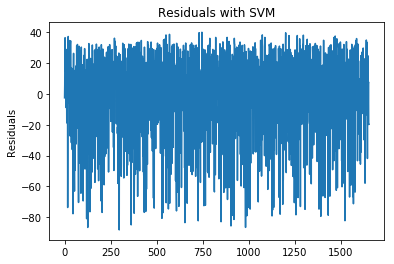

MSE with SVM: 815.246070769
r-squared with svm: 0.00589229455888


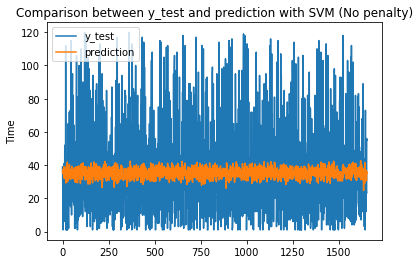

In [29]:
########### SVM
clf = SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
    kernel='sigmoid', max_iter=1000, shrinking=True, tol=0.0001, verbose=False)
clf.fit(X_train, y_train)

prediction_svm = clf.predict(X_test)
#coefficients_svm = clf.coef_ # kernel='linear'的时候才能使用
intercept_svm = clf.intercept_
print("coefficients:", coefficients_svm)
print("intercept:", intercept_svm)

# revert the prediction value, prediction_ori is the original value for prediction
prediction_svm_ori = prediction_svm*(y.max()-y.min())+y.min()
y_test_ori = np.array(y_test*(y.max()-y.min())+y.min())

# calculate and plot residuals
residuals_svm = prediction_svm_ori - y_test_ori
plt.plot(residuals_svm)
plt.title('Residuals with SVM')
plt.ylabel('Residuals')
plt.show()

# calculate the mse value for the prediciton.
mse_svm = np.mean((prediction_svm_ori-y_test_ori)**2)
print('MSE with SVM:', mse_svm)
r_squared_svm = 1-sum((prediction_svm_ori-y_test_ori)**2)/sum((y_test_ori-np.mean(y_test_ori))**2)
print("r-squared with svm:", r_squared_svm)

# plot the figure to see the difference between prediction and y_test.
plt.plot(y_test_ori,label='y_test')
plt.plot(prediction_svm_ori, label='prediction')
plt.legend()
plt.title('Comparison between y_test and prediction with SVM (No penalty)')
plt.ylabel('Time')
plt.show()


Epoch 1/10
3856/3856 [==============================] - 1s 167us/step - loss: 0.0999 - mean_squared_error: 0.0999
Epoch 2/10
3856/3856 [==============================] - 0s 66us/step - loss: 0.0619 - mean_squared_error: 0.0619

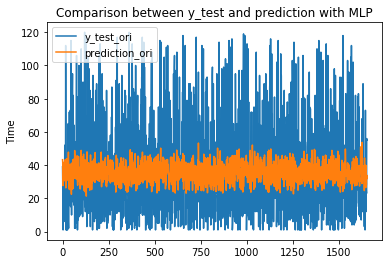

In [27]:
########### Multilayer Perceptron (MLP)

# start to build MLP
model = Sequential()

# add the dense layer, 64 is the output dimension of this layer
# kernel_regularizer is the regularization of l1, l2 and l1_l2(elastic-net), we can choose any of them.
# 0.0001 is the λ
# input_shape is the dimension of the input data. we have 9 features, so it is 9.
model.add(Dense(64,
#                kernel_regularizer=regularizers.l1_l2(0.00001),
                activation='sigmoid',
                input_shape=(9,)))

# add another dense layer, it is the output layer, output a single value.
# the activation function is linear, since we do the regression analysis.
model.add(Dense(1, activation='linear'))

# compile the whole model together. loss function is mse, we use SGD to update the weights and biase.
# the lr is the learning rate, we choose 0.001.
# metrics is the 'mean_squared_error'
model.compile(loss=losses.mse,
              optimizer=SGD(lr=0.001),
              metrics=['mean_squared_error'])

# after creating the MLP, we can fit the model by using the training data.
# batch_size is for the SGD.
# epochs means every 10 epoch we record the result.
# verbose means we show the history of the model process.
hist = model.fit(x=X_train,
                 y=y_train,
                 batch_size=32,
                 epochs=10,
                 verbose=1)

# when we train the model, we can give the prediction for the test x
prediction_mlp = model.predict(X_test, batch_size=32)

# revert the prediction value
prediction_mlp_ori = prediction_mlp*(y.max()-y.min())+y.min()
y_test_ori = y_test*(y.max()-y.min())+y.min()

# we can evaluate data to see the model accuracy.
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

# calculate the mse for the prediction
prediction_mlp_ori = prediction_mlp_ori.reshape(len(prediction_mlp_ori), )
# type(prediction)
y_test_ori = np.array(y_test_ori)
mse_mlp = np.mean((prediction_mlp_ori - y_test_ori) ** 2)
print("MSE with MLP:", mse_mlp)
r_squared_mlp = 1-sum((prediction_mlp_ori-y_test_ori)**2)/sum((y_test_ori-np.mean(y_test_ori))**2)
print("r-squared with mlp:", r_squared_mlp)

### plot the figure to observe the differece between y_test and prediction.
plt.plot(y_test_ori, label='y_test_ori')
plt.plot(prediction_mlp_ori, label='prediction_ori')
plt.title('Comparison between y_test and prediction with MLP')
plt.ylabel('Time')
plt.legend()
plt.show()